# Analysis of Coordinate Descent

We use CD as the algorithm for minimizing Free Energy. I am interested in whether I can halt progress in one coordinate (i.e. one recognition factor) and how much that affects FEM globally. In this notebook, I play around with an example to gain some intuition.

In [1]:
using Distributions
using Random
using StatsPlots
using Plots
pyplot()
include("util.jl")

mean_chain (generic function with 1 method)

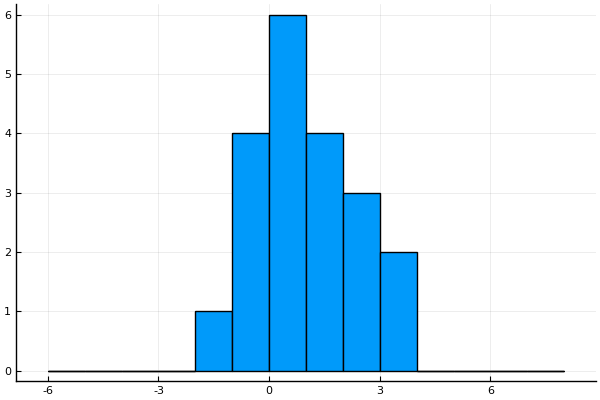

In [2]:
# Some random data

n = 20
x = rand(Normal(1,sqrt(2)), n)

histogram(x, bins=range(-6, stop=8), label="")

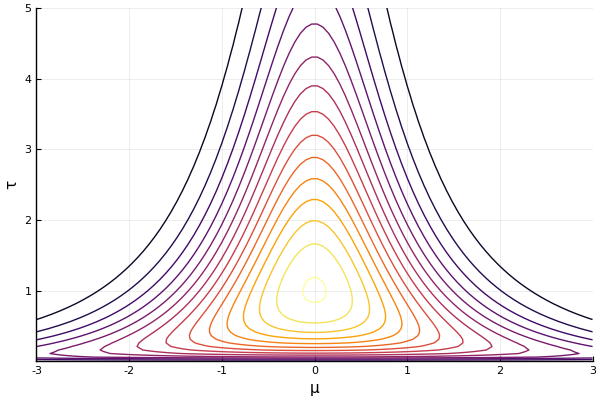

In [3]:
# Prior parameters
m_0 = 0
l_0 = 1
a_0 = 1
b_0 = 1/2

# Visualize prior
plot_normalgamma(m_0, l_0, a_0, b_0, 
                 x1=range(-3, stop=3, length=100), 
                 x2=range(0.01, stop=5, length=100))

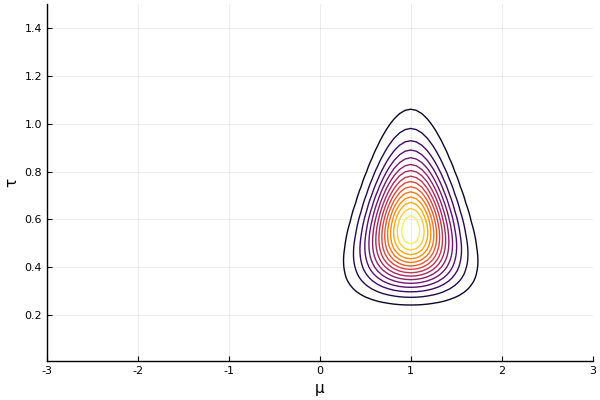

In [4]:
# Convenience variables
x_ = mean(x)
x__ = var(x)

# Parameters of the posterior
m = (l_0 * m_0 + n*mean(x))/(l_0 + n)
l = l_0 + n
a = a_0 + n/2
b = b_0 + 1/2*(n*var(x) + (l_0*n*(mean(x) - m_0)^2)/(l_0 + n))

# Visualize posterior
plot_normalgamma(m, l, a, b, 
                 x1=range(-3, stop=3, length=100), 
                 x2=range(0.01, stop=1.5, length=100))

The generative model has the form: $p(\mu, \tau \mid x) \propto p(x \mid \mu, \tau) p(\mu, \tau)$. We construct the following recognition distribution to approximate the posterior: $ q(\mu, \tau) = q(\mu) \ q(\tau)$ where 

$$ \begin{align} q(\mu) \sim& \ \mathcal{N}(m_{\mu}, v_{\mu}) \\ q(\tau) \sim& \ \Gamma(a_{\tau}, b_{\tau}) \, . \end{align}$$
If we minimize the variational free energy, 

$$\mathcal{F}[q] = \int q(\mu) q(\tau)\log \frac{q(\mu)q(\tau)}{p(\mu, \tau \mid x)} \mathrm{d}\mu \mathrm{d}\tau \, ,$$

we obtain the following forms for the optimal recognition factors:

$$ \begin{align} q^{*}(\mu) \propto& \ \exp\big(\mathbb{E}_{q(\tau)} [-\log \mathcal{N}(x \mid \mu, \tau)] + \mathbb{E}_{q(\tau)} [-\log \mathcal{NG}\ (\mu, \tau \mid m_0, l_0, a_0, b_0)] \big) \propto \ \mathcal{N}(\mu \mid m_{\mu}^{*}, v_{\mu}^{*}) \\
q^{*}(\tau) \propto& \ \exp \big(\mathbb{E}_{q(\mu)} [-\log \mathcal{N}(x \mid \mu, \tau)] + \mathbb{E}_{q(\mu)} [-\log \mathcal{NG}\ (\mu, \tau \mid m_0, l_0, a_0, b_0)] \big) \propto \Gamma(\tau \mid a_{\tau}^{*}, b_{\tau}^{*}) \end{align}$$

with parameters:

$$ \begin{align}  
m_{\mu}^{*} =& \ (n \bar{x} + l_0 m_0 )\ /\ (n + l_0 ) \\
v_{\mu}^{*} =& \ \big( \frac{a_{\tau}}{b_{\tau}}(n  + l_0) \big)^{-1} \\
a_{\tau}^{*} =& \ a_0 + \frac{n+1}{2} \\ 
b_{\tau}^{*} =& \ b_0 + \frac{1}{2}\big[l_0(m_0^{2} - 2m_0 m_{\mu} + m_{\mu}^2 + v_{\mu}) + n(\tilde{x} - 2 \bar{x} m_{\mu} + m_{\mu}^{2} + v_{\mu})\big]
 \end{align}$$
 
where $\tilde{x} = \frac{1}{n} \sum_{i=1}^{n} x_i^2$. We initialize the recognition distribution's parameters and iteratively update them until convergence.

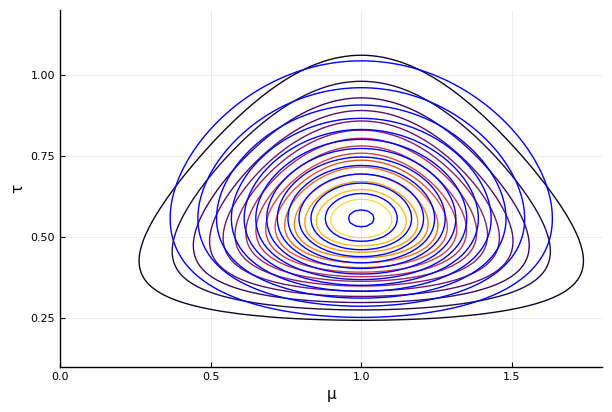

┌ Info: Saved animation to 
│   fn = /home/wmkouw/Dropbox/Research/tueindhoven/reactiveMP/schedulefreeMP/analysis/viz/CD01.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/home/wmkouw/Dropbox/Research/tueindhoven/reactiveMP/schedulefreeMP/analysis/viz/CD01.gif")
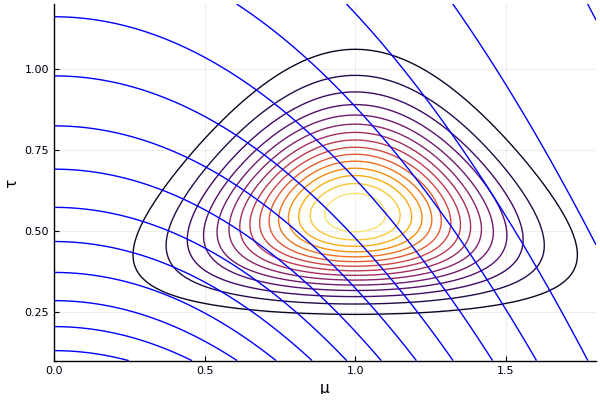

In [10]:
let

# Initialize recognition parameters
global v_μ = 1
global m_μ = 0
global a_τ = 1
global b_τ = 1

# Iterate update rules
animation = @animate for i = 1:10
        
    # Visualize true posterior
    plot_normalgamma(m, l, a, b, 
                     x1=range(0, stop=1.8, length=100), 
                     x2=range(0.1, stop=1.2, length=100),
                     overlay=false)
    
    # Visualize recognition distributions
    plot_normal_gamma(m_μ, v_μ, a_τ, b_τ, 
                      color="blue",
                      label="approx. post.",
                      x1=range(0, stop=1.8, length=100), 
                      x2=range(0.1, stop=1.2, length=100),
                      overlay=true)
        
    # Update variational parameters
    m_μ = (n*mean(x) + l_0*m_0) / (n + l_0)
    v_μ = inv((n + l_0)* a_τ / b_τ)
    a_τ = a_0 + (n+1)/2
    b_τ = b_0 + 1/2*(l_0*(m_0^2 - 2*m_0*m_μ + m_μ^2 + v_μ) + n*(mean(x.^2) -2*mean(x)*m_μ + m_μ^2 + v_μ))
    
end
    
gif(animation, "viz/CD01.gif", fps = 2)
end